In [10]:
from pathlib import Path
import duckdb
ROOT = Path.cwd().parent

csv_path = ROOT / "data" / "PremierLeague.csv"
db_path = ROOT / "pl.duckdb"

con = duckdb.connect(str(db_path))

con.execute(f"""
    CREATE OR REPLACE TABLE matches AS
    SELECT * FROM read_csv_auto('{csv_path.as_posix()}', HEADER=TRUE);
""")

In [11]:
df_cards = con.execute("""
WITH long AS (
  SELECT HomeTeam AS team,
         HomeTeamFouls        AS fouls,
         HomeTeamYellowCards  AS yellows,
         HomeTeamRedCards     AS reds
  FROM matches
  UNION ALL
  SELECT AwayTeam,
         AwayTeamFouls,
         AwayTeamYellowCards,
         AwayTeamRedCards
  FROM matches
)
SELECT team,
       SUM(fouls)   AS total_fouls,
       SUM(yellows) AS total_yellows,
       SUM(reds)    AS total_reds,
       ROUND(1.0*SUM(yellows)/NULLIF(SUM(fouls),0),3) AS yellows_per_foul,
       ROUND(1.0*SUM(reds)/NULLIF(SUM(fouls),0),3)    AS reds_per_foul
FROM long
GROUP BY team
ORDER BY yellows_per_foul ASC;
""").df()

In [12]:
df_season_cards = con.execute("""
WITH long AS (
  SELECT Season, HomeTeam AS team,
         HomeTeamFouls       AS fouls,
         HomeTeamYellowCards AS yellows,
         HomeTeamRedCards    AS reds
  FROM matches
  UNION ALL
  SELECT Season, AwayTeam,
         AwayTeamFouls,
         AwayTeamYellowCards,
         AwayTeamRedCards
  FROM matches
)
SELECT Season, team,
       SUM(fouls)   AS total_fouls,
       SUM(yellows) AS total_yellows,
       SUM(reds)    AS total_reds,
       ROUND(1.0*SUM(yellows)/NULLIF(SUM(fouls),0),3) AS yellows_per_foul,
       ROUND(1.0*SUM(reds)/NULLIF(SUM(fouls),0),3)    AS reds_per_foul
FROM long
GROUP BY Season, team
ORDER BY Season, team;
""").df()

big6 = [
    "Arsenal", "Chelsea", "Liverpool", 
    "Manchester City", "Manchester United", 
    "Tottenham"
]

df_big6 = df_season_cards[df_season_cards["team"].isin(big6)]



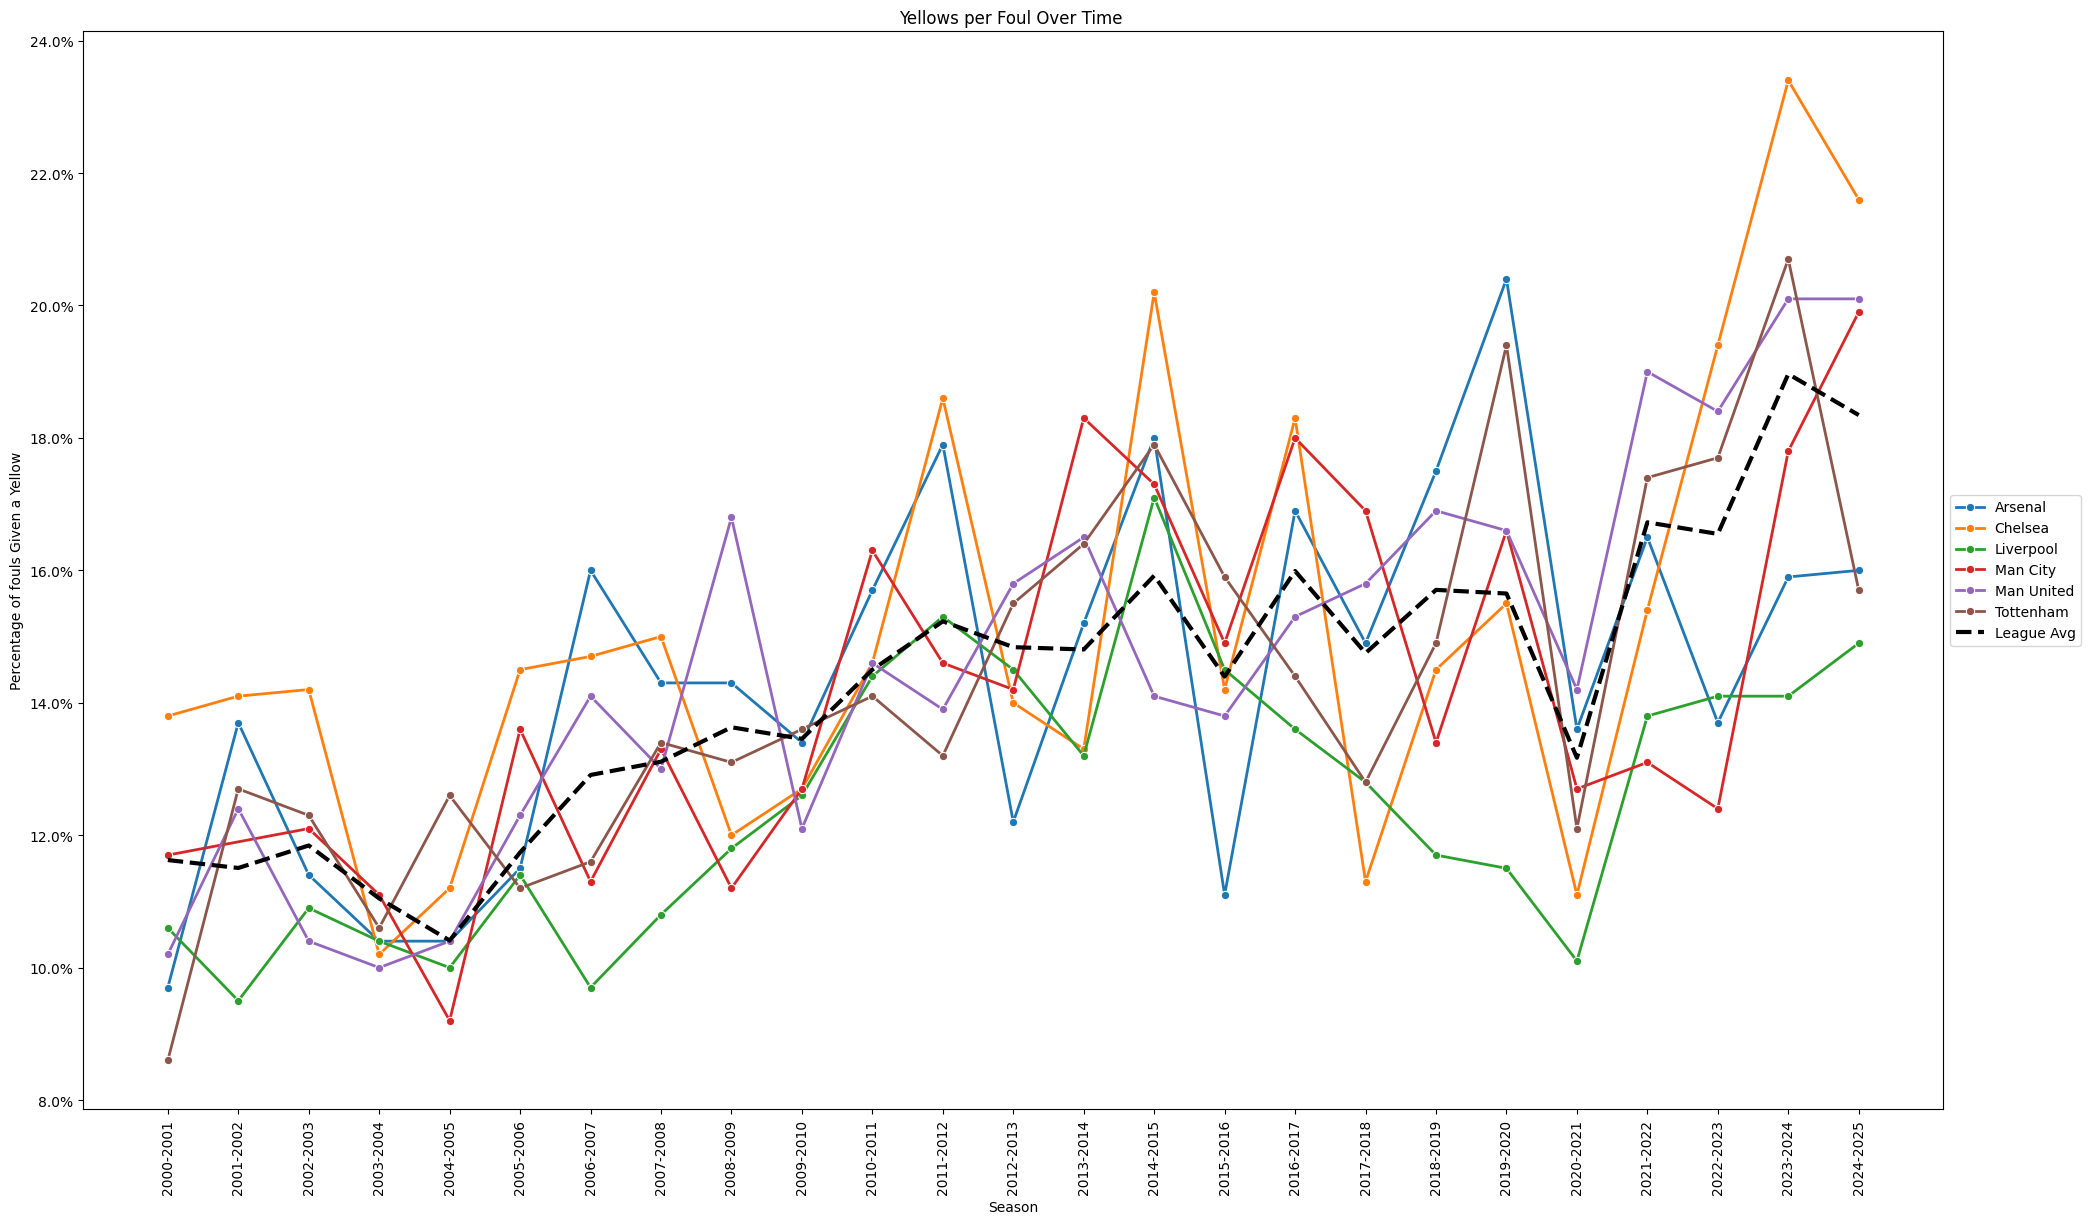

In [27]:
import os, re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

os.makedirs("../figures", exist_ok=True)


df_season_cards["season_start"] = df_season_cards["Season"].str.slice(0, 4).astype(int)
df_season_cards = df_season_cards[df_season_cards["season_start"] >= 2000].copy()


season_order = sorted(df_season_cards["Season"].unique(), key=season_key)
df_season_cards["Season"] = pd.Categorical(df_season_cards["Season"], categories=season_order, ordered=True)

big6 = ["Arsenal", "Chelsea", "Liverpool", "Man City", "Man United", "Tottenham"]


df_big6 = df_season_cards[df_season_cards["team"].isin(big6)].copy()

plt.figure(figsize=(24, 14))
sns.lineplot(
    data=df_big6,
    x="Season", y="yellows_per_foul", hue="team",
    marker="o", linewidth=2
)

league_avg = (
    df_season_cards.groupby("Season", observed=True)["yellows_per_foul"]
    .mean().reset_index()
)
sns.lineplot(
    data=league_avg,
    x="Season", y="yellows_per_foul",
    color="black", linewidth=3, linestyle="--", label="League Avg"
)

import matplotlib.ticker as mtick

plt.title("Yellows per Foul Over Time ")
plt.xlabel("Season")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel("Percentage of fouls Given a Yellow")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.savefig("../figures/yellows_per_foul_big6_2000.png", dpi=300, bbox_inches="tight")
plt.show()

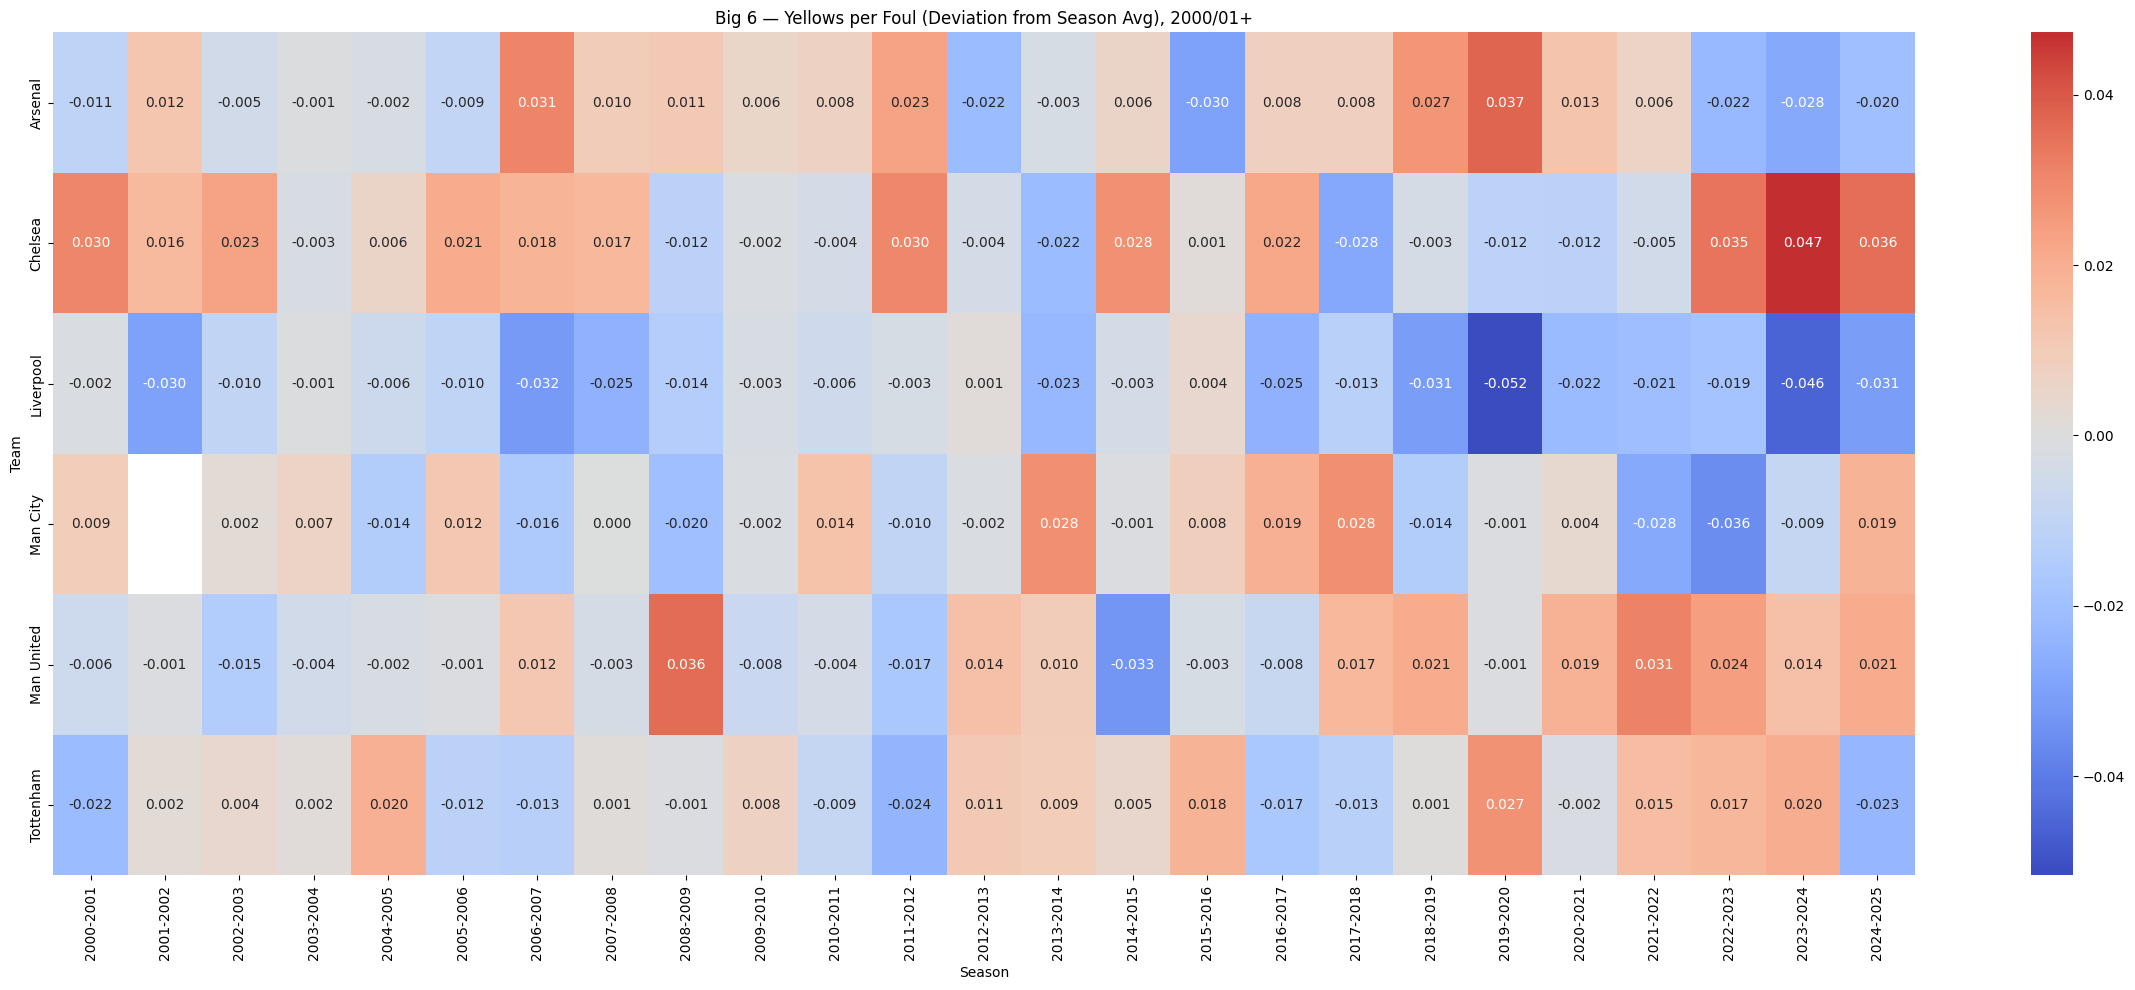

In [14]:
raw_piv = df_season_cards.pivot(index="team", columns="Season", values="yellows_per_foul")
raw_piv = raw_piv.loc[raw_piv.index.intersection(big6)]
raw_piv = raw_piv.reindex(columns=season_order)

rel_piv = raw_piv - raw_piv.mean(axis=0)

plt.figure(figsize=(24, 10))
sns.heatmap(rel_piv, annot=True, fmt=".3f", cmap="coolwarm", center=0)
plt.title("Big 6 — Yellows per Foul (Deviation from Season Avg), 2000/01+")
plt.xlabel("Season")
plt.xticks(rotation=90)
plt.ylabel("Team")
plt.tight_layout()
#plt.savefig("../figures/heatmap_yellows_per_foul_big6_relative.png", dpi=300, bbox_inches="tight")
plt.show()